In [9]:
!pwd

/cluster/home/taekim/stressed_mice/jupyter_notebooks


In [16]:
#This is for cleaning data to ensure there are no NaN values

import pandas as pd
import numpy as np

# 1. Read the CSV file
file_path = '../data_normalized/gene_bodies_Normalized.csv'  #CHANGE PATH
df = pd.read_csv(file_path)


# 2. View the first few rows to understand the data
print("First 5 rows of the dataset:")
print(df.head())

# 3. Get basic information about the dataset
print("\nDataset information:")
print(df.info())

# 4. Check for missing values
print("\nMissing values per column:")
print(df.isnull().sum())


# 5. Delete unwanted columns
#columns_to_drop = ['Unnamed: 0.1', 'Unnamed: 0']  # Replace with actual column names
#df_cleaned = df.drop(columns=columns_to_drop)

# 6. Remove rows with missing values
# Instead of filling NaN values with zeros, drop the rows containing NaN values
#df_cleaned_no_nan = df.copy()
#df_cleaned_no_nan.dropna(inplace=True)  # Remove rows with any NaN values

# 7. Check the result
#print("\nCleaned dataset (first 5 rows):")
#print(df_cleaned_no_nan.head())  # Using option B as an example

#df_cleaned_no_nan.to_csv('../data_normalized/cpg_cleaned_Normalized.csv', index=False) #CHANGE PATH
#print("\nCleaned data saved!")


First 5 rows of the dataset:
                    id                      sample                gene strand  \
0  ENSMUSG00000000001-  Sample_01_Ctrl_morning_S1_  ENSMUSG00000000001      -   
1  ENSMUSG00000000003-  Sample_01_Ctrl_morning_S1_  ENSMUSG00000000003      -   
2  ENSMUSG00000000028-  Sample_01_Ctrl_morning_S1_  ENSMUSG00000000028      -   
3  ENSMUSG00000000031-  Sample_01_Ctrl_morning_S1_  ENSMUSG00000000031      -   
4  ENSMUSG00000000037-  Sample_01_Ctrl_morning_S1_  ENSMUSG00000000037      -   

   GC_count  damage  GC_normalized_damage    median  median_normalized_damage  \
0      8786      47              0.005349  6.921409                  0.772880   
1      3036      13              0.004282  6.921409                  0.618653   
2      7274      63              0.008661  6.921409                  1.251333   
3      1475       5              0.003390  6.921409                  0.489760   
4     16839      55              0.003266  6.921409                  0.471902  

Available columns: ['id', 'sample', 'gene', 'strand', 'GC_count', 'damage', 'GC_normalized_damage', 'median', 'median_normalized_damage', 'chromosome']
NaN count in original dataframe:
id                          0
sample                      0
gene                        0
strand                      0
GC_count                    0
damage                      0
GC_normalized_damage        0
median                      0
median_normalized_damage    0
chromosome                  0
dtype: int64

Pivot table shape: (20, 152236)
NaN count in pivot table:
0

Sample of pivot table (first 5 rows, first 5 columns):
FeatureID                   ENSMUSG00000000001+  ENSMUSG00000000001-  \
sample                                                                 
Sample_01_Ctrl_morning_S1_             0.546531             0.386440   
Sample_02_CRS_morning_S2_              0.349476             0.517234   
Sample_03_Ctrl_morning_S3_             0.368589             0.501622   
Sample_04_CRS_morning_S4_

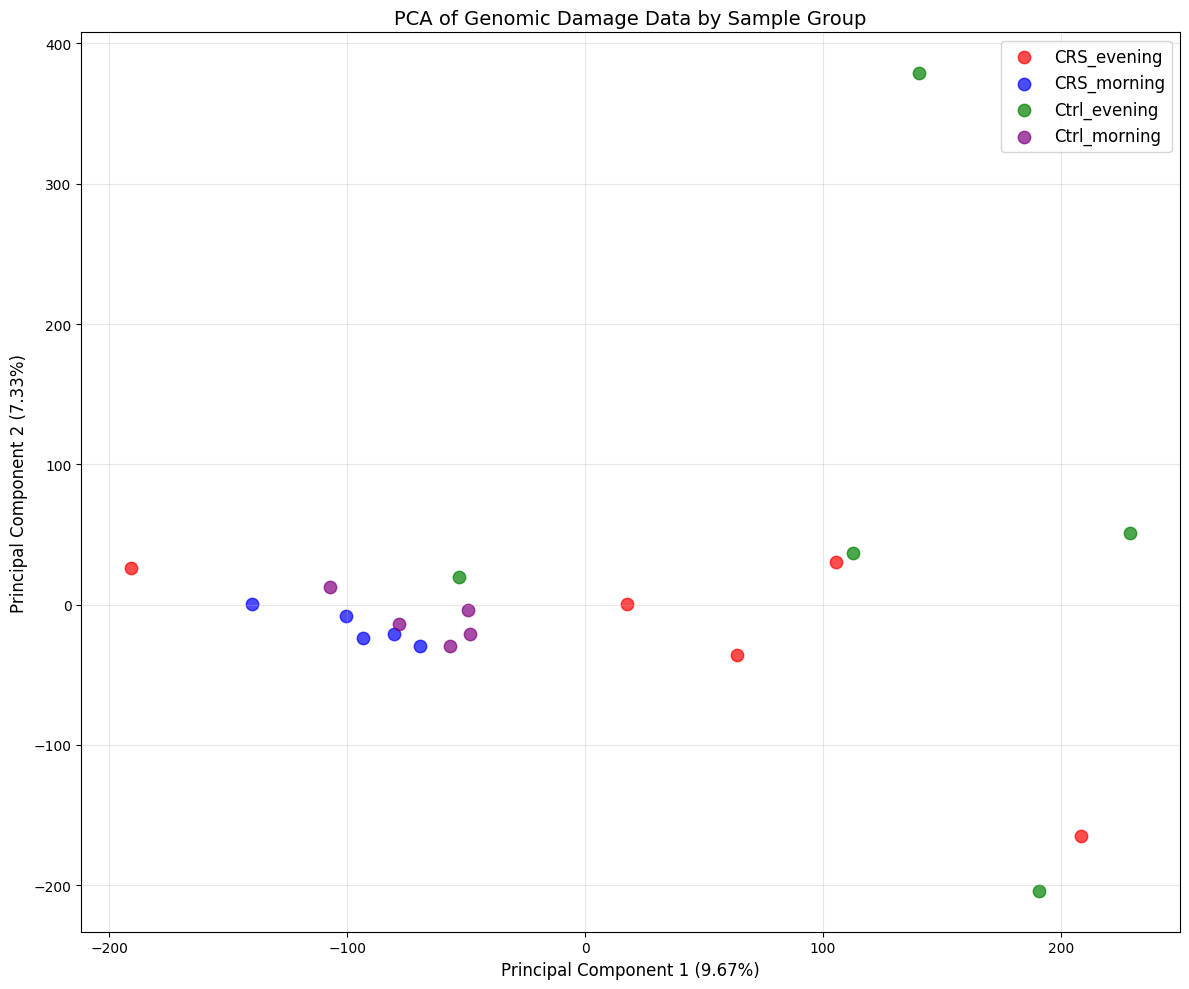

Saved scree plot to ../images/pca_results/gene_bodies/pca_scree_plot.png


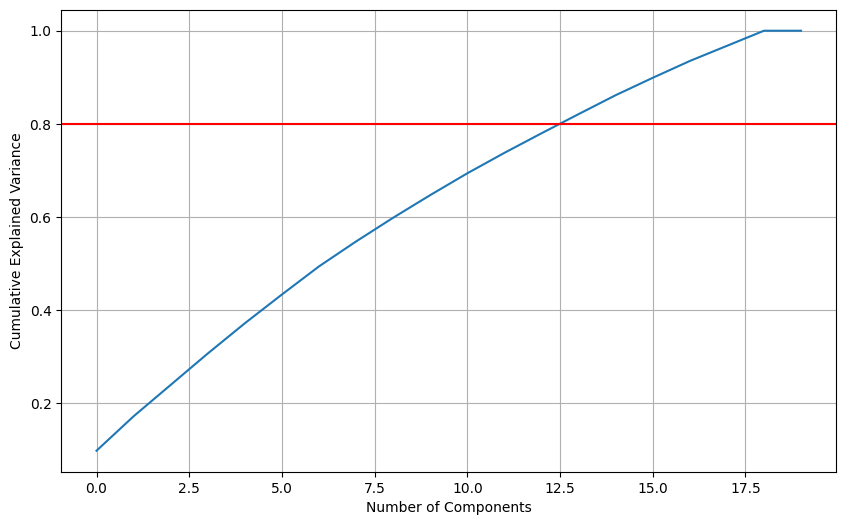

Saved 3D PCA plot to ../images/pca_results/gene_bodies/pca_3d_plot.png


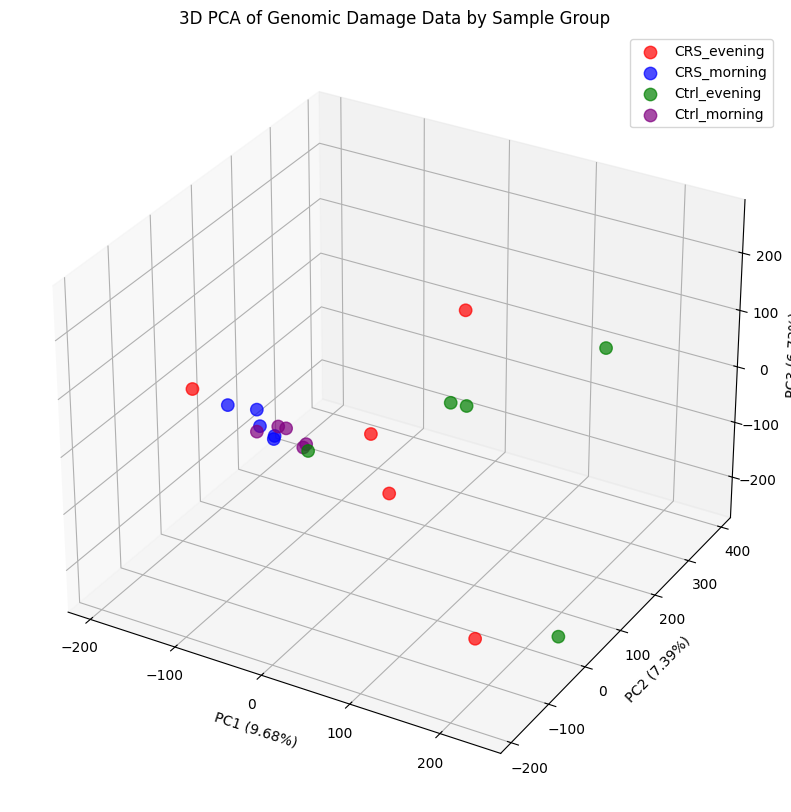

In [17]:
# PCA implementation 
import numpy as np
import sys
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import re
import os

# Extract bin size from file path
file_path = '../data_normalized/gene_bodies_Normalized.csv'
#bin_size = re.search(r'Normalized_(\d+)', file_path).group(1)

# Create directory if it doesn't exist
image_output_dir = '../images/pca_results/gene_bodies'
csv_output_dir = '../data_dim_reduction/gene_bodies'
os.makedirs(image_output_dir, exist_ok=True)
os.makedirs(csv_output_dir, exist_ok=True)

# Read the CSV file
df = pd.read_csv(file_path)

# 1. Check the first few rows of the modified dataframe
#print("Sample of the modified dataframe:")
#print(df[['Sample', 'Bin', 'Strand', 'FeatureID', 'Group', 'Median_Normalized_Damage']].head(10))
#print("\n")
print("Available columns:", df.columns.tolist())
print("NaN count in original dataframe:")
print(df.isna().sum())



# Create FeatureID using the correct column names
df['FeatureID'] = df['id'].astype(str)

# Group using the correct column names (lowercase 'sample')
df['Group'] = df.groupby(['sample', 'FeatureID']).cumcount().astype(str)

# Create the pivot table with correct column names
pivot_df = df.pivot_table(index='sample', 
                          columns='FeatureID', 
                          values='median_normalized_damage',
                          aggfunc='mean')

# Check for NaN values in the pivot table
print("\nPivot table shape:", pivot_df.shape)
print("NaN count in pivot table:")
print(pivot_df.isna().sum().sum())

print("\nSample of pivot table (first 5 rows, first 5 columns):")
print(pivot_df.iloc[:5, :5])

# Convert to numpy array for PCA and scale data
X = pivot_df.values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

#  Apply PCA
pca = PCA(n_components=2)  # Reduce to 2 dimensions
X_pca = pca.fit_transform(X_scaled)
print("Explained variance ratio:", pca.explained_variance_ratio_)
print("Cumulative explained variance:", sum(pca.explained_variance_ratio_))

# Save loadings dataframe
loadings = pca.components_
loadings_df = pd.DataFrame(loadings.T, columns=['PC1', 'PC2'], index=pivot_df.columns)
print(loadings_df)

# Save loadings dataframe to CSV
loadings_filename = os.path.join(csv_output_dir, f'pca_loadings.csv')
loadings_df.to_csv(loadings_filename)
print(f"Saved loadings to {loadings_filename}")

# Extract sample groups from sample names
def extract_group(sample_name):
    # Use regex to extract the group part (CRS_evening, CRS_morning, etc.)
    match = re.search(r'(CRS|Ctrl)_(evening|morning)', sample_name)
    if match:
        return match.group(0)
    else:
        return "Unknown"

# Create a DataFrame with PCA results
pca_df = pd.DataFrame(data=X_pca, columns=['PC1', 'PC2'], index=pivot_df.index)

# Extract groups from sample names
pca_df['group'] = pca_df.index.map(extract_group)

# Define colors for each group
colors = {'CRS_evening': 'red', 'CRS_morning': 'blue',  'Ctrl_evening': 'green', 'Ctrl_morning': 'purple'}

# Plot with color by group
plt.figure(figsize=(12, 10))

# Plot each group separately for the legend
for group, color in colors.items():
    group_data = pca_df[pca_df['group'] == group]
    plt.scatter(group_data['PC1'], group_data['PC2'], c=color, label=group, alpha=0.7, s=80)

# Add labels and details
plt.xlabel(f'Principal Component 1 ({pca.explained_variance_ratio_[0]:.2%})', fontsize=12)
plt.ylabel(f'Principal Component 2 ({pca.explained_variance_ratio_[1]:.2%})', fontsize=12)
plt.title('PCA of Genomic Damage Data by Sample Group', fontsize=14)
plt.grid(alpha=0.3)
plt.legend(fontsize=12)
plt.tight_layout()

# Save the 2D PCA plot
pca_2d_filename = os.path.join(image_output_dir, f'pca_2d_plot.png')
plt.savefig(pca_2d_filename, dpi=300)
print(f"Saved 2D PCA plot to {pca_2d_filename}")
plt.show()

# Create scree plot
pca_full = PCA().fit(X_scaled)
plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(pca_full.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.axhline(y=0.8, color='r', linestyle='-')
plt.grid()

# Save the scree plot
scree_filename = os.path.join(image_output_dir, f'pca_scree_plot.png')
plt.savefig(scree_filename, dpi=300)
print(f"Saved scree plot to {scree_filename}")
plt.show()

# Optional: Also create a 3D plot
from mpl_toolkits.mplot3d import Axes3D

# Compute 3D PCA if desired
pca3d = PCA(n_components=3)
X_pca3d = pca3d.fit_transform(X_scaled)
pca_df_3d = pd.DataFrame(data=X_pca3d, columns=['PC1', 'PC2', 'PC3'], index=pivot_df.index)
pca_df_3d['group'] = pca_df_3d.index.map(extract_group)

# Create 3D plot
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

# Plot each group
for group, color in colors.items():
    group_data = pca_df_3d[pca_df_3d['group'] == group]
    ax.scatter(group_data['PC1'], group_data['PC2'], group_data['PC3'],  c=color, label=group, alpha=0.7, s=80)

ax.set_xlabel(f'PC1 ({pca3d.explained_variance_ratio_[0]:.2%})')
ax.set_ylabel(f'PC2 ({pca3d.explained_variance_ratio_[1]:.2%})')
ax.set_zlabel(f'PC3 ({pca3d.explained_variance_ratio_[2]:.2%})')
ax.legend()
plt.title('3D PCA of Genomic Damage Data by Sample Group')

# Save the 3D PCA plot
pca_3d_filename = os.path.join(image_output_dir, f'pca_3d_plot.png')
plt.savefig(pca_3d_filename, dpi=300)
print(f"Saved 3D PCA plot to {pca_3d_filename}")
plt.show()

Running t-SNE with perplexity=5
[t-SNE] Computing 16 nearest neighbors...
[t-SNE] Indexed 20 samples in 0.016s...
[t-SNE] Computed neighbors for 20 samples in 0.064s...
[t-SNE] Computed conditional probabilities for sample 20 / 20
[t-SNE] Mean sigma: 102.532645
[t-SNE] KL divergence after 250 iterations with early exaggeration: 91.743378
[t-SNE] KL divergence after 3050 iterations: 0.662794
Running t-SNE with perplexity=10
[t-SNE] Computing 19 nearest neighbors...
[t-SNE] Indexed 20 samples in 0.020s...
[t-SNE] Computed neighbors for 20 samples in 0.045s...
[t-SNE] Computed conditional probabilities for sample 20 / 20
[t-SNE] Mean sigma: 150.045493
[t-SNE] KL divergence after 250 iterations with early exaggeration: 72.301376
[t-SNE] KL divergence after 1450 iterations: 0.335708
Running t-SNE with perplexity=15
[t-SNE] Computing 19 nearest neighbors...
[t-SNE] Indexed 20 samples in 0.020s...
[t-SNE] Computed neighbors for 20 samples in 0.016s...
[t-SNE] Computed conditional probabilitie

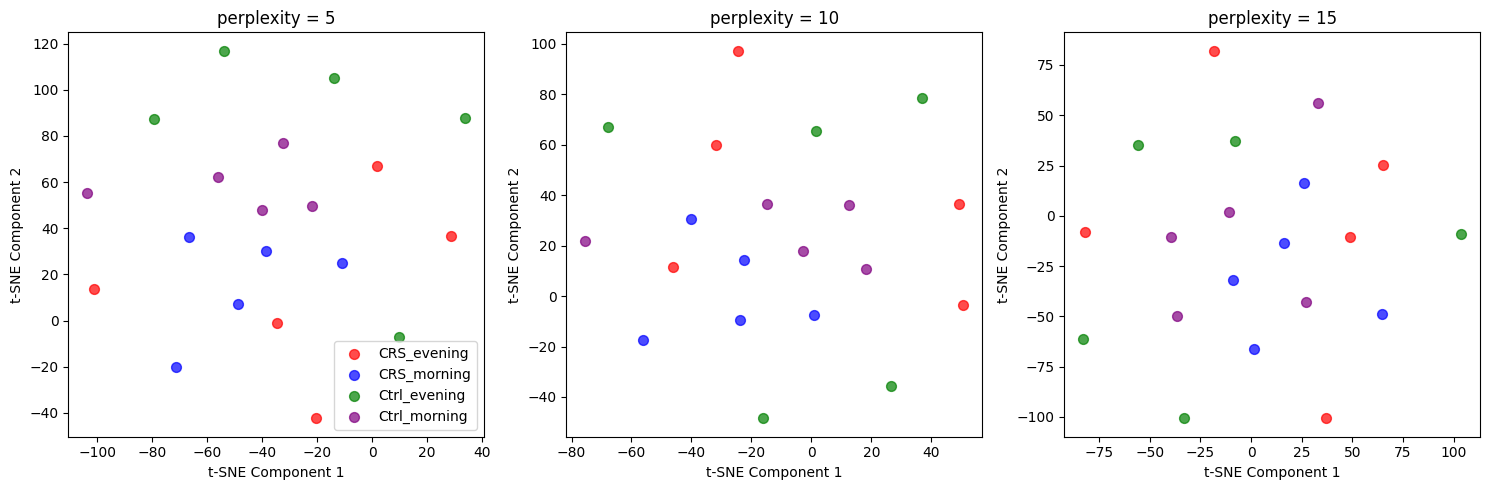

Running 3D t-SNE with perplexity=5
[t-SNE] Computing 16 nearest neighbors...
[t-SNE] Indexed 20 samples in 0.018s...
[t-SNE] Computed neighbors for 20 samples in 0.020s...
[t-SNE] Computed conditional probabilities for sample 20 / 20
[t-SNE] Mean sigma: 102.532645
[t-SNE] KL divergence after 250 iterations with early exaggeration: 65.664497
[t-SNE] KL divergence after 5000 iterations: 0.739455
Running 3D t-SNE with perplexity=10
[t-SNE] Computing 19 nearest neighbors...
[t-SNE] Indexed 20 samples in 0.018s...
[t-SNE] Computed neighbors for 20 samples in 0.076s...
[t-SNE] Computed conditional probabilities for sample 20 / 20
[t-SNE] Mean sigma: 150.045493
[t-SNE] KL divergence after 250 iterations with early exaggeration: 125.314926
[t-SNE] KL divergence after 5000 iterations: 0.480056
Running 3D t-SNE with perplexity=15
[t-SNE] Computing 19 nearest neighbors...
[t-SNE] Indexed 20 samples in 0.018s...
[t-SNE] Computed neighbors for 20 samples in 0.039s...
[t-SNE] Computed conditional pr

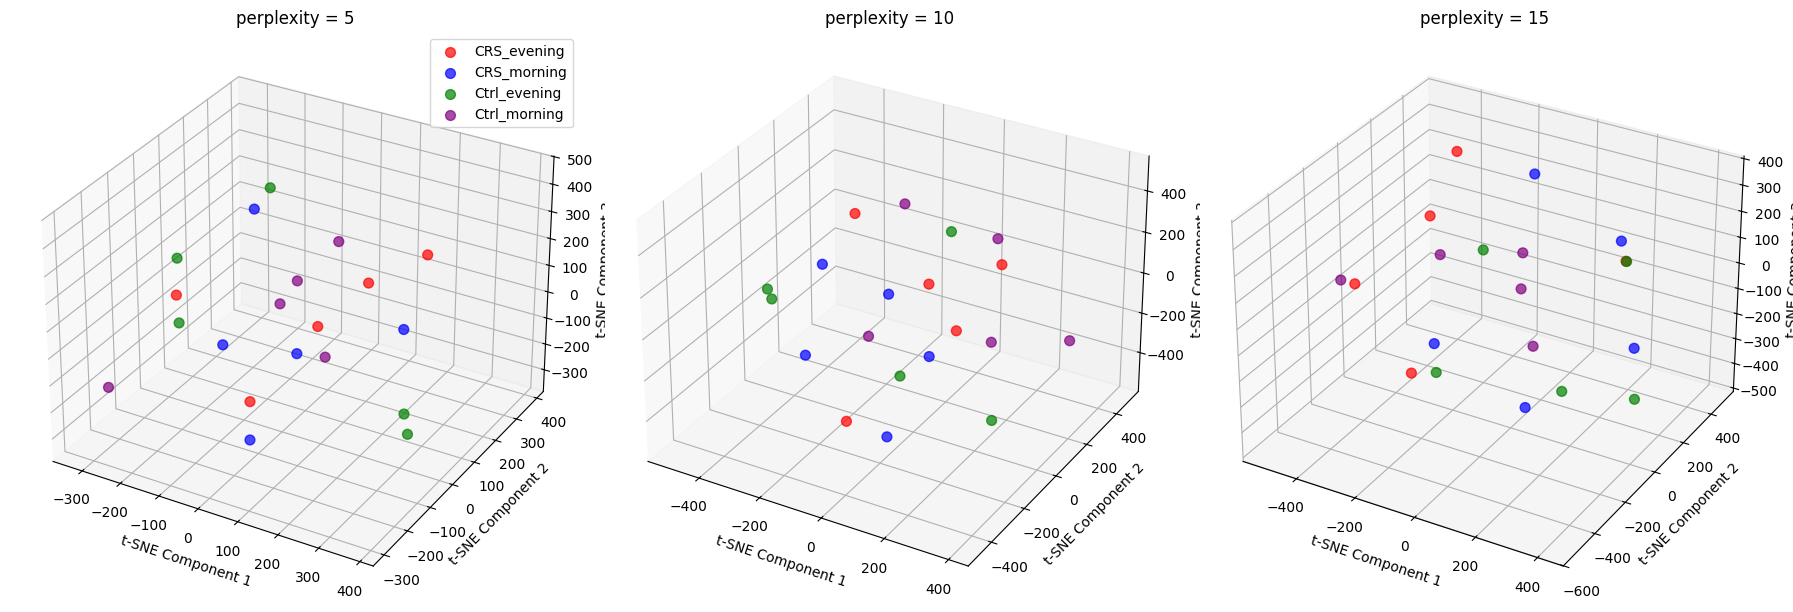

All t-SNE analyses completed!


In [18]:
#tSNE
import numpy as np
import pandas as pd
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import re
import os

# Extract bin size from file path
file_path = '../data_normalized/gene_bodies_Normalized.csv'
#bin_size = re.search(r'Normalized_(\d+)', file_path).group(1)

# Create directories if they don't exist
image_output_dir = '../images/tsne_results/gene_bodies'
csv_output_dir = '../data_dim_reduction/gene_bodies'
os.makedirs(image_output_dir, exist_ok=True)
os.makedirs(csv_output_dir, exist_ok=True)

# Read the CSV file
df = pd.read_csv(file_path)

# Create FeatureID using the correct column names
df['FeatureID'] = df['id'].astype(str)

# Group using the correct column names (lowercase 'sample')
df['Group'] = df.groupby(['sample', 'FeatureID']).cumcount().astype(str)

# Create the pivot table with correct column names
pivot_df = df.pivot_table(index='sample', 
                          columns='FeatureID', 
                          values='median_normalized_damage',
                          aggfunc='mean')

# Convert to numpy array and scale data
X = pivot_df.values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Extract sample groups from sample names
def extract_group(sample_name):
    # Use regex to extract the group part (CRS_evening, CRS_morning, etc.)
    match = re.search(r'(CRS|Ctrl)_(evening|morning)', sample_name)
    if match:
        return match.group(0)
    else:
        return "Unknown"

# Define colors for each group
colors = {
    'CRS_evening': 'red',
    'CRS_morning': 'blue',
    'Ctrl_evening': 'green',
    'Ctrl_morning': 'purple'
}

# List of perplexity values to try
perplexity_values = [5, 10, 15]
n_values = len(perplexity_values)

# Create a figure with subplots
fig, axes = plt.subplots(1, n_values, figsize=(n_values*5, 5))

# Apply t-SNE with different perplexity values
for i, perplexity in enumerate(perplexity_values):
    # Ensure perplexity is smaller than n_samples
    if perplexity >= X_scaled.shape[0]:
        perplexity = X_scaled.shape[0] - 1
    
    print(f"Running t-SNE with perplexity={perplexity}")
    
    # Apply t-SNE
    tsne = TSNE(n_components=2, perplexity=perplexity, random_state=42, 
                max_iter=5000, verbose=1)
    X_tsne = tsne.fit_transform(X_scaled)
    
    # Create a DataFrame with t-SNE results
    temp_df = pd.DataFrame(data=X_tsne, columns=['TSNE1', 'TSNE2'], index=pivot_df.index)
    
    # Extract groups from sample names
    temp_df['group'] = temp_df.index.map(extract_group)
     
    # Plot with color by group on the corresponding subplot
    for group, color in colors.items():
        group_data = temp_df[temp_df['group'] == group]
        axes[i].scatter(group_data['TSNE1'], group_data['TSNE2'], 
                   c=color, label=group, alpha=0.7, s=50)
    
    axes[i].set_title(f'perplexity = {perplexity}')
    if i == 0:  # Only add legend to the first subplot
        axes[i].legend()
    axes[i].set_xlabel('t-SNE Component 1')
    axes[i].set_ylabel('t-SNE Component 2')

plt.tight_layout()
plt.savefig(os.path.join(image_output_dir, f'tsne_2d_perplexity_comparison.png'), dpi=300)
print(f"Saved perplexity comparison to {os.path.join(image_output_dir, f'tsne_perplexity_comparison.png')}")
plt.show()

# Optional: 3D t-SNE with multiple perplexity values
from mpl_toolkits.mplot3d import Axes3D

# List of perplexity values for 3D visualization (using fewer to keep it manageable)
perplexity_values_3d = [5, 10, 15]
n_values_3d = len(perplexity_values_3d)

# Create a figure for 3D plots
fig = plt.figure(figsize=(n_values_3d*6, 6))

for i, perplexity in enumerate(perplexity_values_3d):
    print(f"Running 3D t-SNE with perplexity={perplexity}")
    
    # Apply 3D t-SNE
    tsne3d = TSNE(n_components=3, perplexity=perplexity, random_state=42, max_iter=5000, verbose=1)
    X_tsne3d = tsne3d.fit_transform(X_scaled)
    
    # Create DataFrame with 3D t-SNE results
    temp_df_3d = pd.DataFrame(data=X_tsne3d, columns=['TSNE1', 'TSNE2', 'TSNE3'], index=pivot_df.index)
    temp_df_3d['group'] = temp_df_3d.index.map(extract_group)
    
        
    # Add to the figure
    ax = fig.add_subplot(1, n_values_3d, i+1, projection='3d')
    
    for group, color in colors.items():
        group_data = temp_df_3d[temp_df_3d['group'] == group]
        ax.scatter(group_data['TSNE1'], group_data['TSNE2'], group_data['TSNE3'], 
                   c=color, label=group, alpha=0.7, s=50)
    
    ax.set_title(f'perplexity = {perplexity}')
    if i == 0:  # Only add legend to the first subplot
        ax.legend()
    ax.set_xlabel('t-SNE Component 1')
    ax.set_ylabel('t-SNE Component 2')
    ax.set_zlabel('t-SNE Component 3')

plt.tight_layout()
plt.savefig(os.path.join(image_output_dir, f'tsne_3d_perplexity_comparison.png'), dpi=300)
print(f"Saved 3D perplexity comparison to {os.path.join(image_output_dir, f'tsne_3d_perplexity_comparison.png')}")
plt.show()

print("All t-SNE analyses completed!")

[t-SNE] Computing 19 nearest neighbors...
[t-SNE] Indexed 20 samples in 0.020s...
[t-SNE] Computed neighbors for 20 samples in 0.086s...
[t-SNE] Computed conditional probabilities for sample 20 / 20
[t-SNE] Mean sigma: 150.045493
[t-SNE] KL divergence after 250 iterations with early exaggeration: 72.301376
[t-SNE] KL divergence after 1450 iterations: 0.335708
Saved 2D t-SNE plot to ../images/tsne_results/gene_bodies/tsne_2d_plot.png


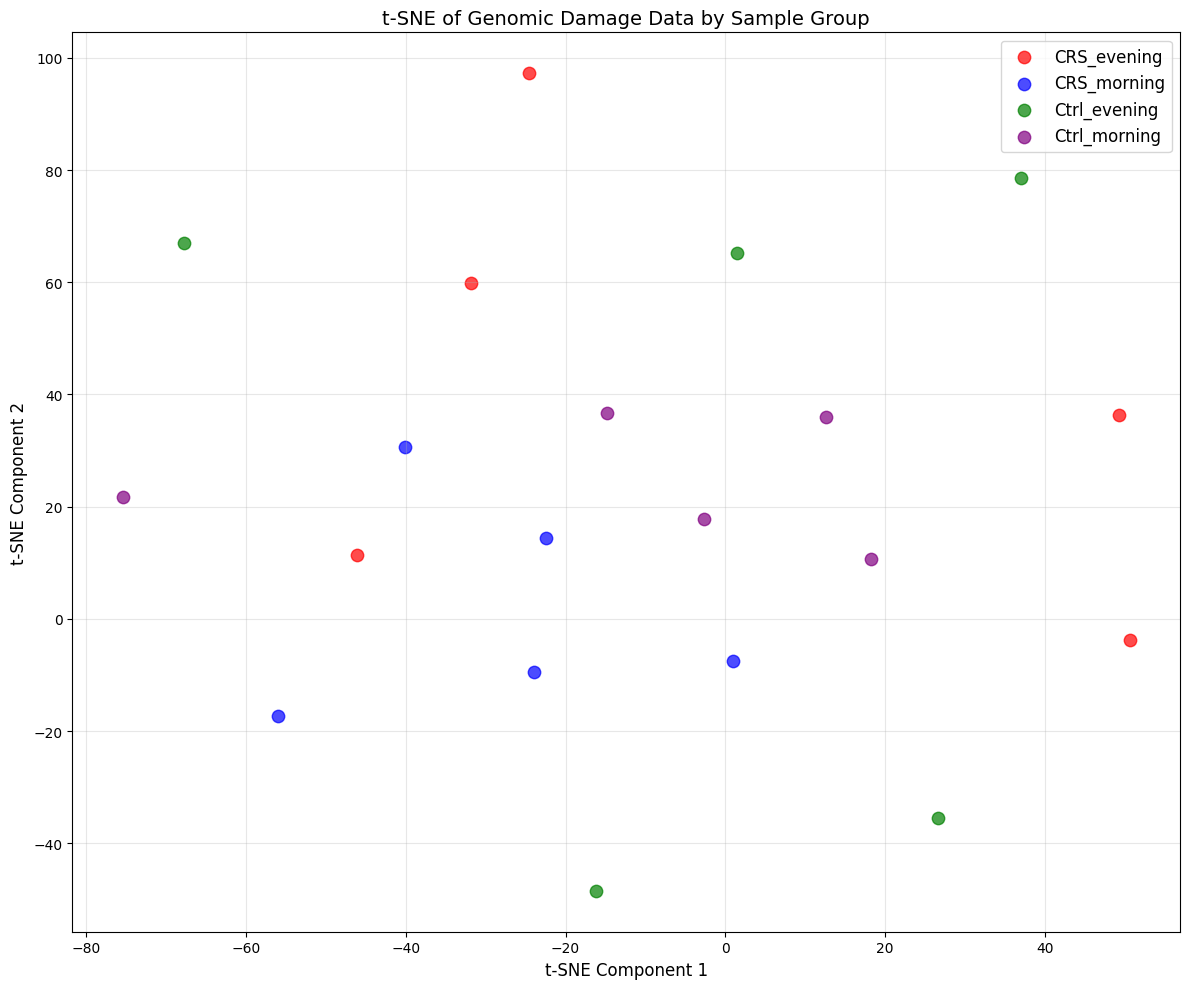

'\n# Optional: 3D t-SNE\nfrom mpl_toolkits.mplot3d import Axes3D\n\nperplexity = 10\n\n# Apply 3D t-SNE\ntsne3d = TSNE(n_components=3, perplexity=perplexity, random_state=42, max_iter=50000, verbose = 1)\nX_tsne3d = tsne3d.fit_transform(X_scaled)\n\n# Create DataFrame with 3D t-SNE results\ntsne_df_3d = pd.DataFrame(data=X_tsne3d, columns=[\'TSNE1\', \'TSNE2\', \'TSNE3\'], index=pivot_df.index)\ntsne_df_3d[\'group\'] = tsne_df_3d.index.map(extract_group)\n\n# Create 3D plot\nfig = plt.figure(figsize=(12, 10))\nax = fig.add_subplot(111, projection=\'3d\')\n\n# Plot each group\nfor group, color in colors.items():\n    group_data = tsne_df_3d[tsne_df_3d[\'group\'] == group]\n    ax.scatter(group_data[\'TSNE1\'], group_data[\'TSNE2\'], group_data[\'TSNE3\'], \n               c=color, label=group, alpha=0.7, s=80)\n\nax.set_xlabel(\'t-SNE Component 1\')\nax.set_ylabel(\'t-SNE Component 2\')\nax.set_zlabel(\'t-SNE Component 3\')\nax.legend()\nplt.title(\'3D t-SNE of Genomic Damage Data by Sa

In [19]:
#t-SNE for best perplexity


perplexity = 10  #EXPERIMENT WITH THIS

tsne = TSNE(n_components=2, perplexity=perplexity, random_state=42, max_iter=50000, verbose = 1)
X_tsne = tsne.fit_transform(X_scaled)

# Create a DataFrame with t-SNE results
tsne_df = pd.DataFrame(data=X_tsne, columns=['TSNE1', 'TSNE2'], index=pivot_df.index)


temp_df.to_csv(os.path.join(csv_output_dir, f'tsne_2d_results_perplexity{perplexity}.csv'))


# Extract groups from sample names
tsne_df['group'] = tsne_df.index.map(extract_group)

# Plot with color by group
plt.figure(figsize=(12, 10))

# Plot each group separately for the legend
for group, color in colors.items():
    group_data = tsne_df[tsne_df['group'] == group]
    plt.scatter(group_data['TSNE1'], group_data['TSNE2'], 
                c=color, label=group, alpha=0.7, s=80)

# Add labels and details
plt.xlabel('t-SNE Component 1', fontsize=12)
plt.ylabel('t-SNE Component 2', fontsize=12)
plt.title('t-SNE of Genomic Damage Data by Sample Group', fontsize=14)
plt.grid(alpha=0.3)
plt.legend(fontsize=12)
plt.tight_layout()

# Save the 2D t-SNE plot
tsne_2d_filename = os.path.join(image_output_dir, f'tsne_2d_plot.png')
plt.savefig(tsne_2d_filename, dpi=300)
print(f"Saved 2D t-SNE plot to {tsne_2d_filename}")
plt.show()
'''
# Optional: 3D t-SNE
from mpl_toolkits.mplot3d import Axes3D

perplexity = 10

# Apply 3D t-SNE
tsne3d = TSNE(n_components=3, perplexity=perplexity, random_state=42, max_iter=50000, verbose = 1)
X_tsne3d = tsne3d.fit_transform(X_scaled)

# Create DataFrame with 3D t-SNE results
tsne_df_3d = pd.DataFrame(data=X_tsne3d, columns=['TSNE1', 'TSNE2', 'TSNE3'], index=pivot_df.index)
tsne_df_3d['group'] = tsne_df_3d.index.map(extract_group)

# Create 3D plot
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

# Plot each group
for group, color in colors.items():
    group_data = tsne_df_3d[tsne_df_3d['group'] == group]
    ax.scatter(group_data['TSNE1'], group_data['TSNE2'], group_data['TSNE3'], 
               c=color, label=group, alpha=0.7, s=80)

ax.set_xlabel('t-SNE Component 1')
ax.set_ylabel('t-SNE Component 2')
ax.set_zlabel('t-SNE Component 3')
ax.legend()
plt.title('3D t-SNE of Genomic Damage Data by Sample Group')

# Save the 3D t-SNE plot
tsne_3d_filename = os.path.join(image_output_dir, f'tsne_3d_plot_bin{bin_size}.png')
plt.savefig(tsne_3d_filename, dpi=300)
print(f"Saved 3D t-SNE plot to {tsne_3d_filename}")
plt.show()

# Save t-SNE results
tsne_df.to_csv(os.path.join(csv_output_dir, f'tsne_results_bin{bin_size}.csv'))
tsne_df_3d.to_csv(os.path.join(csv_output_dir, f'tsne_3d_results_bin{bin_size}.csv'))'''

In [33]:
# Unload current modules (if applicable)
!module unload python-cuda

# Load a compatible python version with older dependencies
!module spider python/3.11.6

!module load stack/2024-05 gcc/13.2.0 python/3.11.6

# Now check your NumPy version
!python3 -c "import numpy; print(numpy.__version__)"

# Install the correct NumPy version




Note: the module "python-cuda" cannot be unloaded because it was not loaded.


----------------------------------------------------------------------------
  python: python/3.11.6
----------------------------------------------------------------------------

    You will need to load all module(s) on any one of the lines below before the "python/3.11.6" module is available to load.

      stack/.2024-05-silent  gcc/13.2.0
      stack/.2024-06-silent  gcc/12.2.0
      stack/2024-05  gcc/13.2.0
      stack/2024-06  gcc/12.2.0
 
    Help:
      The Python programming language.


 

Many modules are hidden in this stack. Use "module --show_hidden spider SOFTWARE" if you are not able to find the required software



The following have been reloaded with a version change:
  1) python/3.11.6_cuda => python/3.11.6

1.26.0


  Using cached numpy-1.26.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (58 kB)
Using cached numpy-1.26.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.2 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.0
    Uninstalling numpy-1.26.0:
      Successfully uninstalled numpy-1.26.0
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.

[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip3 install --upgrade pip
/bin/bash: line 1: pip: command not found

[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip3 install --upgrade pip
Number of samples: 20
Running UMAP with n_neighbors=5
Running UMAP with n_neighbors=10
Running UMAP with n_neighbors=15


/cluster/home/taekim/.local/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/cluster/home/taekim/.local/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/cluster/home/taekim/.local/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


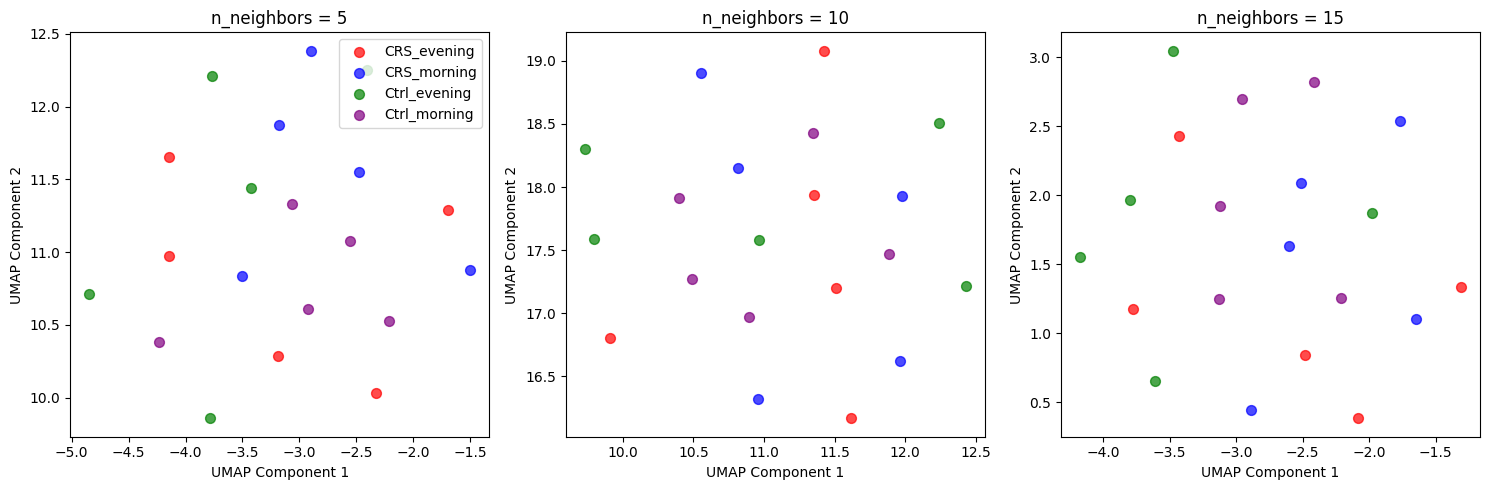

In [20]:
!pip3 install --user numpy==1.26.0 --force-reinstall
!pip install --user numba
!pip3 install --user umap-learn

# Now the rest of your imports
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import re
import os
# Don't import umap again - we already did it above
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import re
import os
import umap  # Make sure to install with: pip install umap-learn
from mpl_toolkits.mplot3d import Axes3D

# Extract bin size from file path
file_path = '../data_normalized/cpg_Normalized.csv'
#bin_size = re.search(r'Normalized_(\d+)', file_path).group(1)

# Create directory if it doesn't exist
# Create directory if it doesn't exist
image_output_dir = '../images/umap_results/cpg'
csv_output_dir = '../data_dim_reduction/cpg'
os.makedirs(image_output_dir, exist_ok=True)
os.makedirs(csv_output_dir, exist_ok=True)
# Read the CSV file
df = pd.read_csv(file_path)

# Convert Bin to string before concatenating
df['FeatureID'] = df['id'].astype(str)
df['Group'] = df.groupby(['sample', 'FeatureID']).cumcount().astype(str)


# Create the pivot table
pivot_df = df.pivot_table(index='sample', 
                         columns='FeatureID', 
                         values='median_normalized_damage',
                         aggfunc='mean')

# Convert to numpy array and scale data
X = pivot_df.values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Get number of samples
n_samples = X_scaled.shape[0]
print(f"Number of samples: {n_samples}")

# Define extract_group function
def extract_group(sample_name):
    # Use regex to extract the group part (CRS_evening, CRS_morning, etc.)
    match = re.search(r'(CRS|Ctrl)_(evening|morning)', sample_name)
    if match:
        return match.group(0)
    else:
        return "Unknown"

# Define colors for each group
colors = {
    'CRS_evening': 'red',
    'CRS_morning': 'blue',
    'Ctrl_evening': 'green',
    'Ctrl_morning': 'purple'
}

# PART 1: Compare different n_neighbors values
neighbors_values = [5, 10, 15]
n_values = len(neighbors_values)
fig, axes = plt.subplots(1, n_values, figsize=(n_values*5, 5))

for i, nn in enumerate(neighbors_values):
    # Ensure n_neighbors is smaller than n_samples
    if nn >= X_scaled.shape[0]:
        nn = X_scaled.shape[0] - 1
    
    print(f"Running UMAP with n_neighbors={nn}")
    reducer = umap.UMAP(n_neighbors=nn, min_dist=0.1, n_components=2, random_state=42)
    X_umap = reducer.fit_transform(X_scaled)
    
    # Create DataFrame with results
    temp_df = pd.DataFrame(data=X_umap, columns=['UMAP1', 'UMAP2'], index=pivot_df.index)
    temp_df['group'] = temp_df.index.map(extract_group)
    
    # Save this specific result
    #temp_df.to_csv(os.path.join(output_dir, f'umap_results_neighbors{nn}_bin{bin_size}.csv'))
    
    # Plot
    for group, color in colors.items():
        group_data = temp_df[temp_df['group'] == group]
        axes[i].scatter(group_data['UMAP1'], group_data['UMAP2'], 
                    c=color, label=group, alpha=0.7, s=50)
    
    axes[i].set_title(f'n_neighbors = {nn}')
    if i == 0:
        axes[i].legend()
    axes[i].set_xlabel('UMAP Component 1')
    axes[i].set_ylabel('UMAP Component 2')

plt.tight_layout()
plt.savefig(os.path.join(image_output_dir, f'umap_neighbors_comparison.png'), dpi=300)
# print(f"Saved n_neighbors comparison to {os.path.join(output_dir, f'umap_neighbors_comparison_bin{bin_size}.png')}")
plt.show()




Running UMAP with min_dist=0.0
Running UMAP with min_dist=0.1
Running UMAP with min_dist=0.5


/cluster/home/taekim/.local/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/cluster/home/taekim/.local/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/cluster/home/taekim/.local/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Running UMAP with min_dist=0.99


/cluster/home/taekim/.local/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


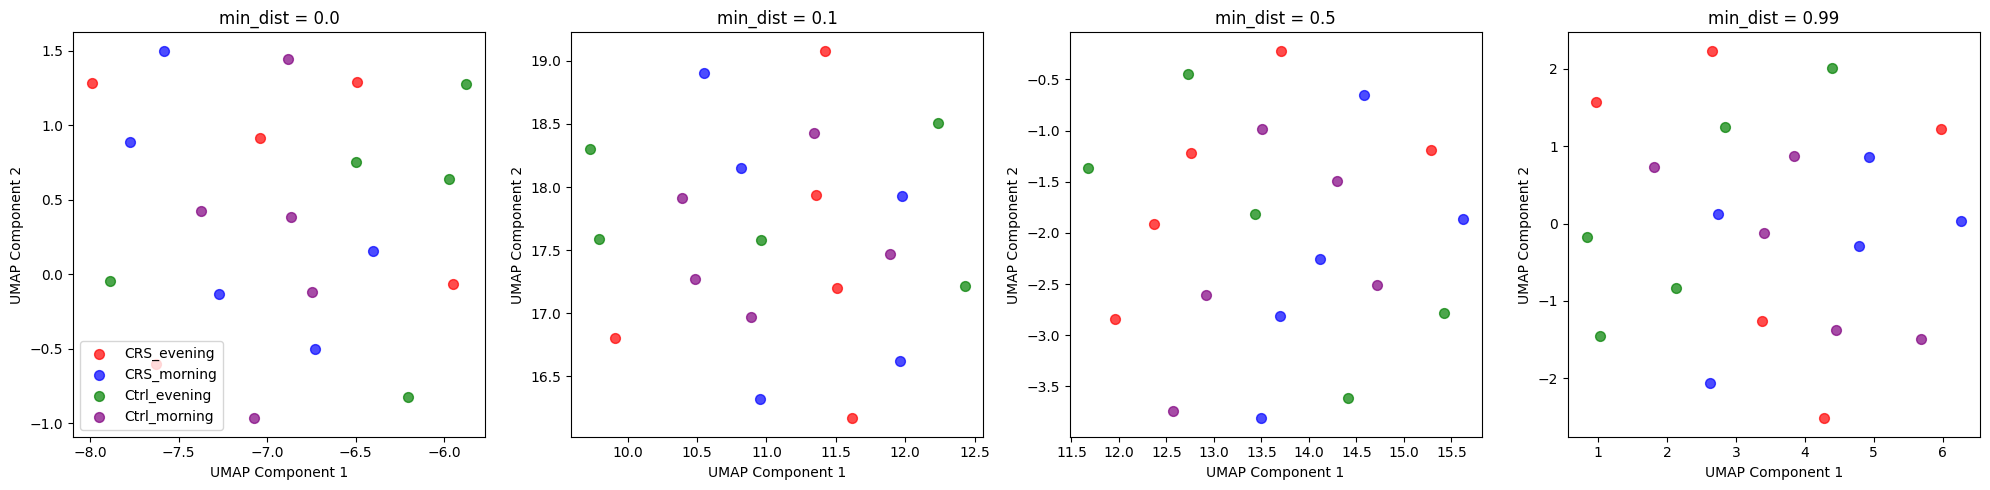

In [21]:
# PART 2: Compare different min_dist values
n_neighbors = 10  # Use the value you found best from the previous experiment
min_dist_values = [0.0, 0.1, 0.5, 0.99]
n_values = len(min_dist_values)
fig, axes = plt.subplots(1, n_values, figsize=(n_values*5, 5))

for i, md in enumerate(min_dist_values):
    print(f"Running UMAP with min_dist={md}")
    reducer = umap.UMAP(n_neighbors=n_neighbors, min_dist=md, n_components=2, random_state=42)
    X_umap = reducer.fit_transform(X_scaled)
    
    # Create DataFrame with results
    temp_df = pd.DataFrame(data=X_umap, columns=['UMAP1', 'UMAP2'], index=pivot_df.index)
    temp_df['group'] = temp_df.index.map(extract_group)
    
    # Save this specific result
    # temp_df.to_csv(os.path.join(output_dir, f'umap_results_mindist{md}_bin{bin_size}.csv'))
    
    # Plot
    for group, color in colors.items():
        group_data = temp_df[temp_df['group'] == group]
        axes[i].scatter(group_data['UMAP1'], group_data['UMAP2'], 
                    c=color, label=group, alpha=0.7, s=50)
    
    axes[i].set_title(f'min_dist = {md}')
    if i == 0:
        axes[i].legend()
    axes[i].set_xlabel('UMAP Component 1')
    axes[i].set_ylabel('UMAP Component 2')

plt.tight_layout()
plt.savefig(os.path.join(image_output_dir, f'umap_mindist_comparison.png'), dpi=300)
# print(f"Saved min_dist comparison to {os.path.join(output_dir, f'umap_mindist_comparison_bin{bin_size}.png')}")
plt.show()

Creating final plots with n_neighbors=5, min_dist=0.1


/cluster/home/taekim/.local/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


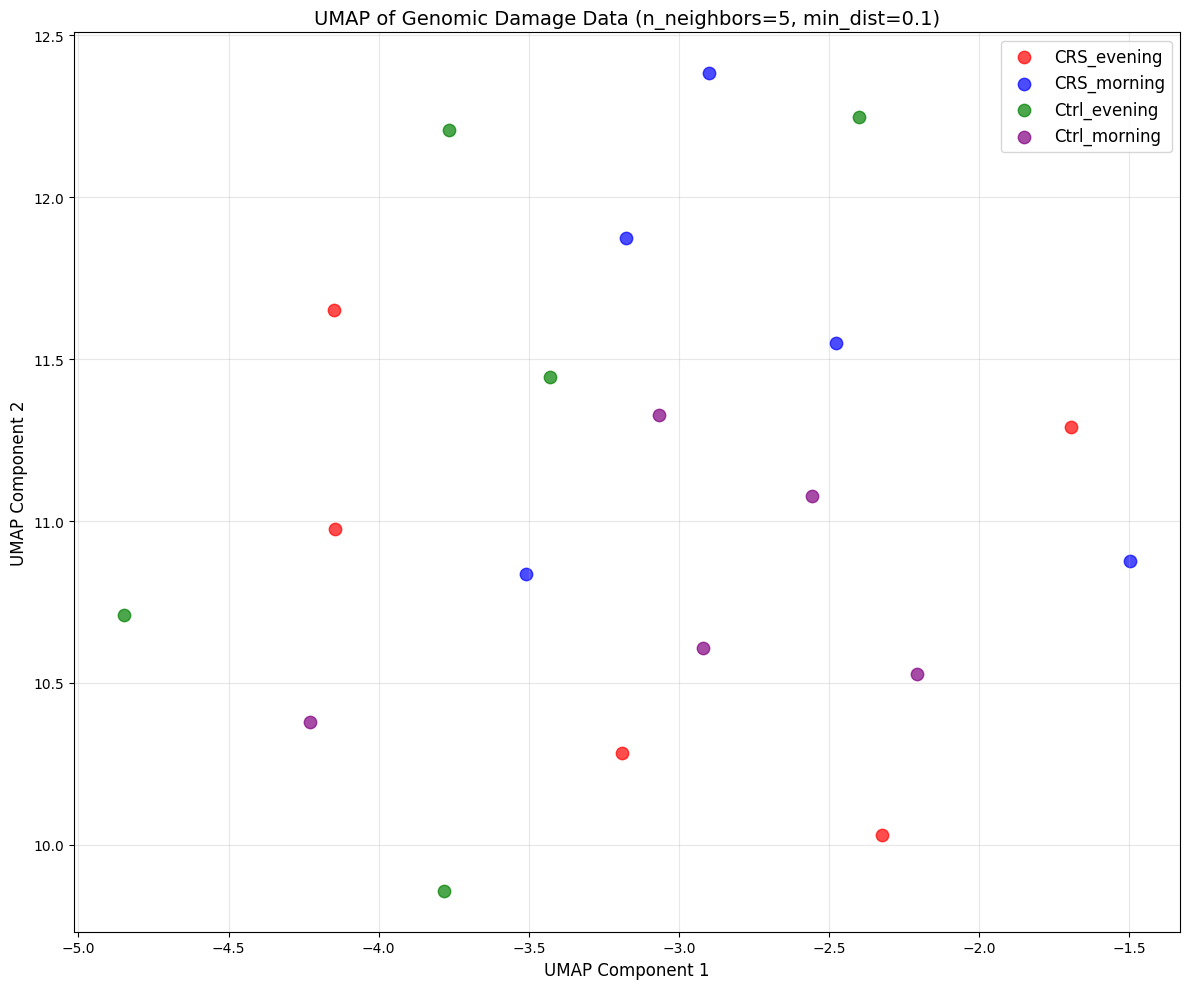

UMAP parameter experimentation complete!


In [22]:
# PART 3: Create final 2D and 3D plots with the optimal parameters
# Use the values you found best from the experiments
best_n_neighbors = 5  # Replace with your optimal value
best_min_dist = 0.1    # Replace with your optimal value

print(f"Creating final plots with n_neighbors={best_n_neighbors}, min_dist={best_min_dist}")

# 2D UMAP with optimal parameters
reducer = umap.UMAP(n_neighbors=best_n_neighbors, 
                    min_dist=best_min_dist, 
                    n_components=2, 
                    random_state=42)
X_umap = reducer.fit_transform(X_scaled)

# Create a DataFrame with UMAP results
umap_df = pd.DataFrame(data=X_umap, columns=['UMAP1', 'UMAP2'], index=pivot_df.index)
umap_df['group'] = umap_df.index.map(extract_group)

# Save final 2D results
umap_df.to_csv(os.path.join(csv_output_dir, f'umap_final_results.csv'))

# Plot with color by group
plt.figure(figsize=(12, 10))

# Plot each group separately for the legend
for group, color in colors.items():
    group_data = umap_df[umap_df['group'] == group]
    plt.scatter(group_data['UMAP1'], group_data['UMAP2'], 
                c=color, label=group, alpha=0.7, s=80)

# Add labels and details
plt.xlabel('UMAP Component 1', fontsize=12)
plt.ylabel('UMAP Component 2', fontsize=12)
plt.title(f'UMAP of Genomic Damage Data (n_neighbors={best_n_neighbors}, min_dist={best_min_dist})', fontsize=14)
plt.grid(alpha=0.3)
plt.legend(fontsize=12)
plt.tight_layout()

# Save the 2D UMAP plot
umap_2d_filename = os.path.join(image_output_dir, f'umap_2d_final_plot.png')
plt.savefig(umap_2d_filename, dpi=300)
# print(f"Saved final 2D UMAP plot to {umap_2d_filename}")
plt.show()

'''
# 3D UMAP with optimal parameters
reducer3d = umap.UMAP(n_neighbors=best_n_neighbors, 
                      min_dist=best_min_dist, 
                      n_components=3, 
                      random_state=42)
X_umap3d = reducer3d.fit_transform(X_scaled)

# Create DataFrame with 3D UMAP results
umap_df_3d = pd.DataFrame(data=X_umap3d, columns=['UMAP1', 'UMAP2', 'UMAP3'], index=pivot_df.index)
umap_df_3d['group'] = umap_df_3d.index.map(extract_group)

# Save final 3D results
# umap_df_3d.to_csv(os.path.join(output_dir, f'umap_3d_final_results_bin{bin_size}.csv'))

# Create 3D plot
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

# Plot each group
for group, color in colors.items():
    group_data = umap_df_3d[umap_df_3d['group'] == group]
    ax.scatter(group_data['UMAP1'], group_data['UMAP2'], group_data['UMAP3'], 
               c=color, label=group, alpha=0.7, s=80)

ax.set_xlabel('UMAP Component 1')
ax.set_ylabel('UMAP Component 2')
ax.set_zlabel('UMAP Component 3')
ax.legend()
plt.title(f'3D UMAP of Genomic Damage Data (n_neighbors={best_n_neighbors}, min_dist={best_min_dist})')

# Save the 3D UMAP plot
# umap_3d_filename = os.path.join(output_dir, f'umap_3d_final_plot_bin{bin_size}.png')
# plt.savefig(umap_3d_filename, dpi=300)
# print(f"Saved final 3D UMAP plot to {umap_3d_filename}")
plt.show()'''

print("UMAP parameter experimentation complete!")
